### Imports

In [1]:
from XRDXRFutils import DatabaseXRD, DataXRD, SpectraXRD, GaussNewton, PhaseList, PhaseMap, PhaseSearch, PhaseMapSave

import os
import pickle


from joblib import Parallel, delayed
import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import linspace,concatenate,sqrt,log,histogram
from matplotlib.pyplot import fill_between,sca,legend,imshow,subplots,plot,xlim,ylim,xlabel,ylabel,cm,title,scatter,colorbar,figure,vlines
from sklearn.cluster import KMeans,MiniBatchKMeans

from PIL import Image

def f_linear(x,a,b):
    return a*x + b
def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

#### Define Paths and Spectra Parameters

In [2]:
path_xrd = '/home/shared/dataXRDXRF/MuseoEgizio2022/VoltoGeroglifici/'
path_database = '/home/shared/DatabaseXRD'

path_data = 'data/' # data of intermediate results, for fast loading
path_figures = 'figures/' # figures generated by the script
path_results = 'results/' # results generated by the script: raw data, tif maps

min_theta = 17
max_theta = 43
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)

#### Read XRD Data

from xrd.h5

In [3]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').save_h5(path_xrd + 'xrd.h5')

Loading: /home/shared/dataXRDXRF/MuseoEgizio2022/VoltoGeroglifici/xrd.h5


#### Display datacube

This is only to check. Shows sum across the spectra dimension.

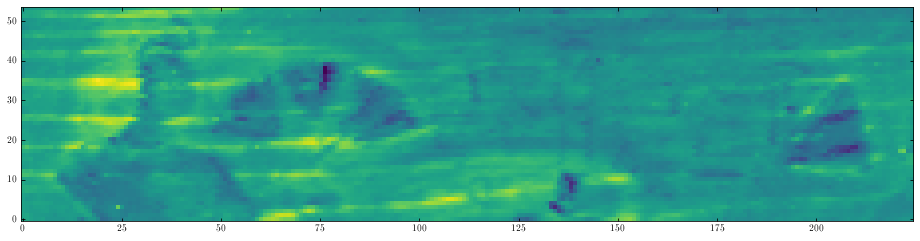

In [4]:
figure(figsize=(16,8))
im = imshow(data.data.sum(axis=2))

For the large datacubes the datasize can be easily reduced using [::n,::n]
where every $n$th pixel is taken

Notes:
Please keep in mind that this rewrites the original dataset so to return the datacube must be reloaded

In [5]:
data.data = data.data[::5,::5]

Display reduced datacube

when $n=3$ every third pixel is taken 

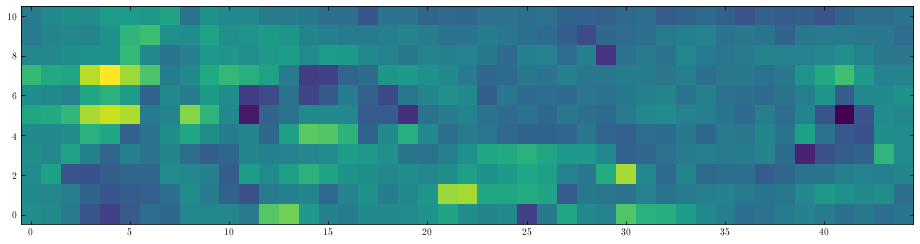

In [6]:
figure(figsize=(16,8))
imshow(data.data.sum(axis=2))

#### Print calibration parameters

In [5]:
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

a: -1327.1 s: 2729.8 beta: 43.202


#### Read database

In [6]:
database = DatabaseXRD().read_cifs(path_database)
print('Phases in database:',len(database))

Phases in database: 117


#### Define Phases

This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [7]:
lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]

orpiment = database['Orpiment'][0]
cuprorivaite = database['Cuprorivaite'][0]

### Autocalibration and Phase Search

Takes 'data' and a list of phases to search for. Searches for phases iterating both $a$ and $s$.

In [8]:
#phases_a_s = PhaseList([hematite,orpiment,cuprorivaite,
#                        PhaseList([orpiment,hematite]),
#                       PhaseList([orpiment,cuprorivaite])])

phases_a_s = PhaseList([hematite,orpiment,cuprorivaite])

print(data.opt)
data.opt[0] = -1323.6
data.opt[1] = 2702.0
print(data.opt)

[-1327.10753327  2729.82284655    43.20211896]
[-1323.6         2702.            43.20211896]


PhaseMap construct a data structures for the minimization.

In [9]:
%%time
pm = PhaseMap(data, phases_a_s,
              sigma_initial = 0.15,
              min_theta = min_theta,
              max_theta = max_theta,
              min_intensity = min_intensity,
              first_n_peaks = first_n_peaks)

sigma initial: 0.15
CPU times: user 40.6 s, sys: 4.08 s, total: 44.7 s
Wall time: 51 s


### Autocalibration and Search
Iterates $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [10]:
%%time
pm.search()

CPU times: user 1min 33s, sys: 10.6 s, total: 1min 43s
Wall time: 1min 54s


### Save and Load

### Histogram of $a$

If $a$ is spead over too large area it might be that the phases are to right or a phase is missing

In [11]:
%%time

opt = pm.opt()
a = opt[...,0]
s = opt[...,1]

CPU times: user 28.9 ms, sys: 0 ns, total: 28.9 ms
Wall time: 27.8 ms


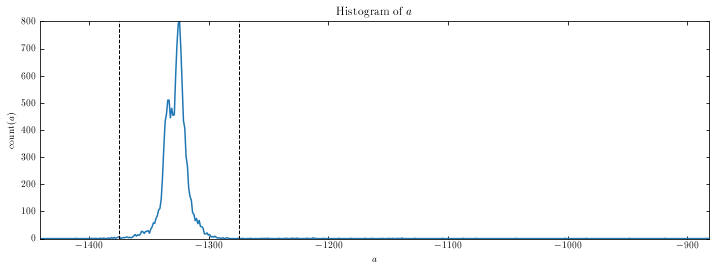

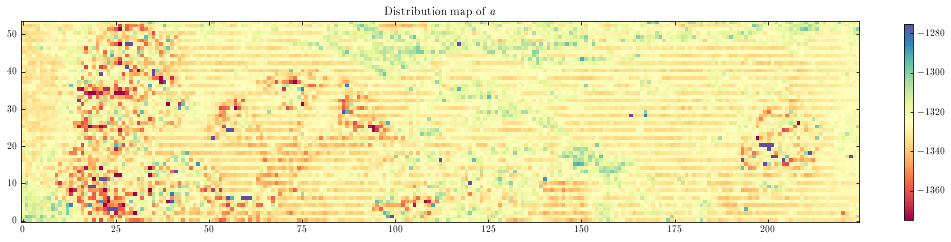

In [12]:
vmin = -1375
vmax = -1275

h,b = histogram(a,bins=512)

figure(figsize=(12,4))

plot(b[:-1],h)
xlim(b[0],b[-1])
ylim(0,h.max())

vlines(vmin,0,h.max(),'k',ls='--',lw=1)
vlines(vmax,0,h.max(),'k',ls='--',lw=1)

xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')

figure(figsize=(16,8))
title('Distribution map of $a$')
im = imshow(a,cmap='Spectral',vmin=vmin,vmax=vmax)
colorbar(im,fraction=0.011)

## Plotting the $a,s$ dependence

There is a slight notion of a second $as$ dependence but it is weak.

In [13]:
opt,var = curve_fit(f_linear,a.flatten(),s.flatten())
res = least_squares(f_loss,x0=opt,args=(a.flatten(),s.flatten()),loss='cauchy')

linear_y = f_linear(a.flatten(),*opt)
cauchy_y = f_linear(a.flatten(),*res['x'])

print('Linear:',opt)
print('Cauchy:',res['x'])

Linear: [   -3.11117198 -1417.67222146]
Cauchy: [ -1.60991784 573.01043697]


-1326.7734943871567 2710.1483041949464


Text(0, 0.5, '$s$')

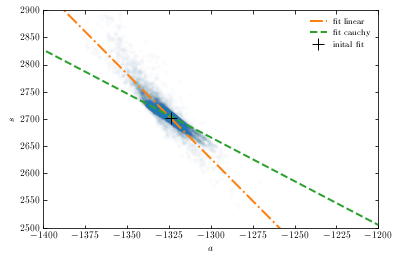

In [14]:
%matplotlib inline
#%matplotlib qt
#plot(a.flatten(),linear_y,ls='--',lw=0.5)
plot(a.flatten(),s.flatten(),'.',alpha=0.01)

x = linspace(a.min(),a.max(),10)
plot(x,f_linear(x,*opt),'-.',lw=2,label='fit linear')
plot(x,f_linear(x,*res['x']),'--',lw=2,label='fit cauchy')
plot(data.opt[0],data.opt[1],'k+',ms=12,label='inital fit')

print(a.mean(),s.mean())

#xlim(-1450,-1200)
#ylim(2200,3200)

xlim(-1400,-1200)
ylim(2500,2900)

legend(frameon=False)

xlabel(r'$a$')
ylabel(r'$s$')

#### Above and Bellow the fit

Separeting the point above and bellow the fit. This does not necceraly work as well as one would hope due to the machine going left and right.

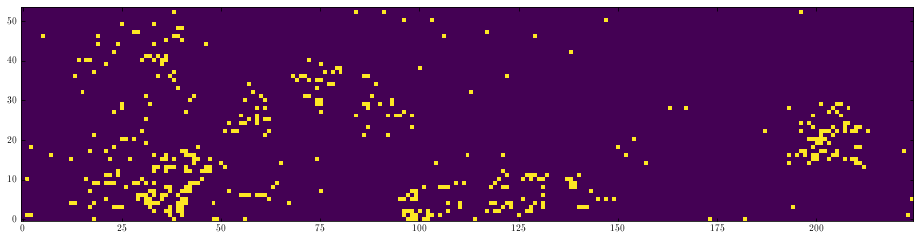

In [15]:
f = s < cauchy_y.reshape(s.shape[0],s.shape[1]) - 20

figure(figsize=(16,8))
imshow(f)

### Clustering

Using clustering on measured $a$ and $s$ provides better maps

In [16]:
w1 = a.flatten()/(s.flatten()**0.5)
w2 = s.flatten()/450

X = concatenate([[w1],[w2]],axis=0).T

In [17]:
kmeans = MiniBatchKMeans(n_clusters=3,n_init=512,batch_size=2048,max_iter=512,verbose=0).fit_predict(X)

Text(0, 0.5, '$s$')

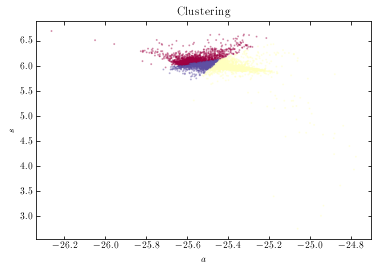

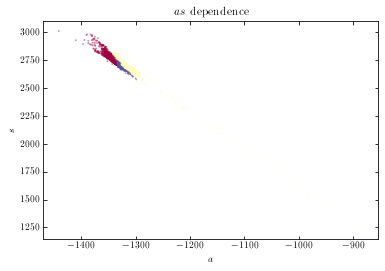

In [18]:
figure()
title('Clustering')
scatter(X[:,0],X[:,1],c=kmeans,s=1,cmap='Spectral',alpha=0.33)
xlabel(r'$a$')
ylabel(r'$s$')

figure()
title('$as$ dependence')
scatter(a.flatten(),s.flatten(),c=kmeans,s=1,cmap='Spectral',alpha=0.33)
xlabel(r'$a$')
ylabel(r'$s$')

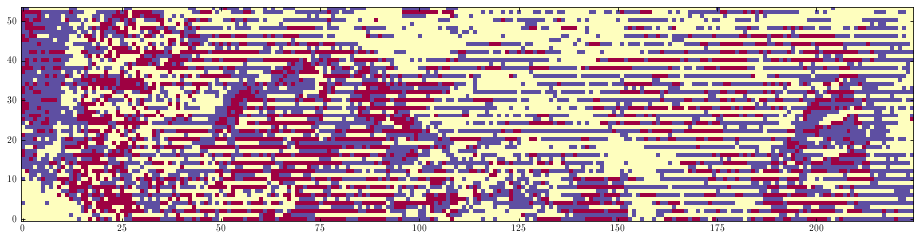

In [19]:
figure(figsize=(16,8))
imshow(kmeans.reshape(a.shape[0],a.shape[1]),cmap='Spectral')

### Fit errrors

Plotting the histograms and maps of the error for each phase. 

In [20]:
loss = sqrt(pm.loss())
loss_0 = sqrt(pm.loss_0())

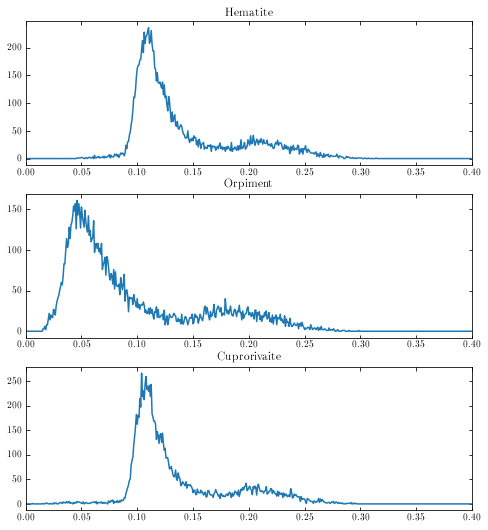

In [21]:
fig,ax = subplots(len(pm.phases),1,figsize=(8,3*len(pm.phases)))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(loss[:,:,i],bins=512,range=(0,0.4))
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,0.4)

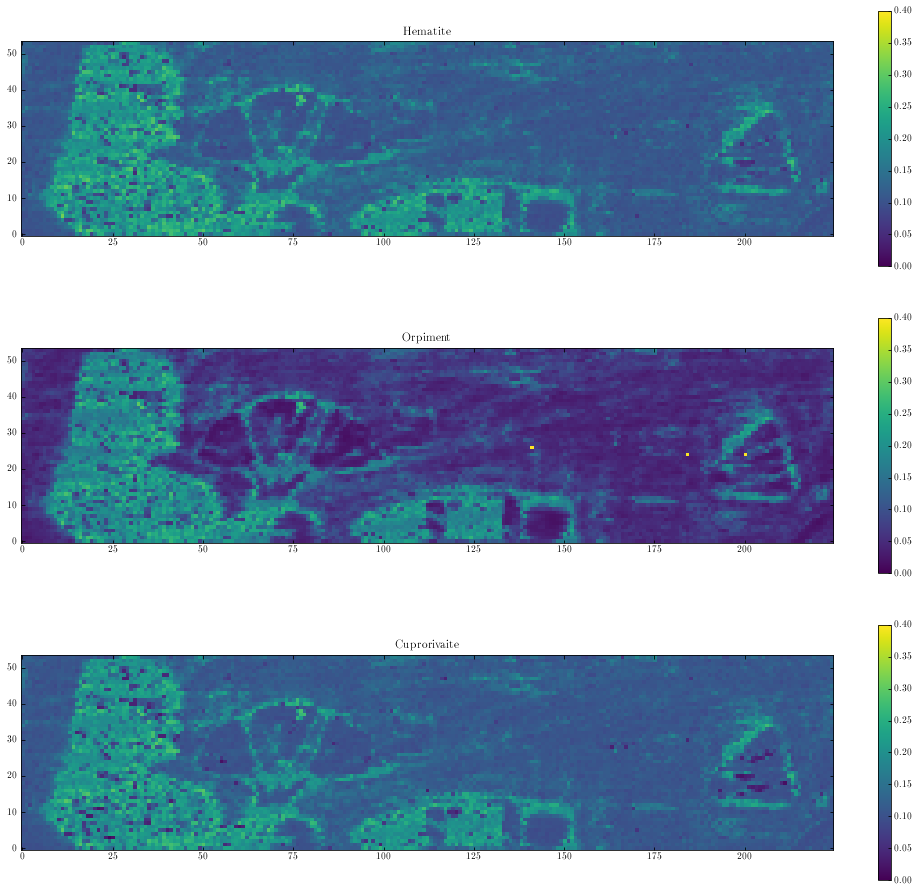

In [22]:
fig,ax = subplots(len(pm.phases),1,figsize=(16,16))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(loss[:,:,i],vmin=0,vmax=0.4)
    p = colorbar(p,ax = ax[i],fraction=0.04)

### Rescaled Loss

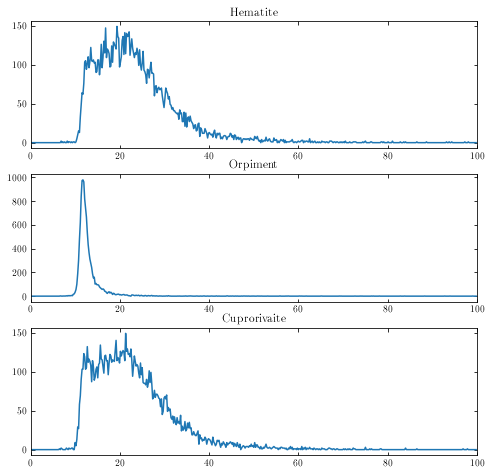

In [23]:
fig,ax = subplots(len(pm.phases),1,figsize=(8,8))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(loss_0[:,:,i],bins=512,range=(0,100))
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,100)

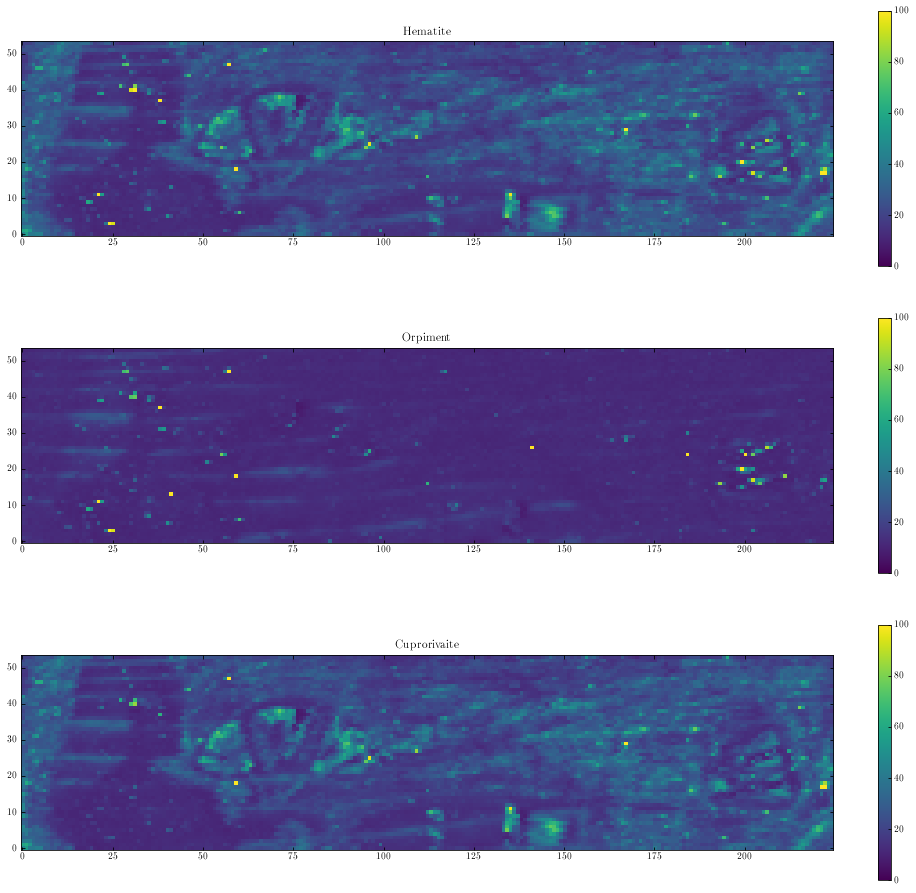

In [24]:
fig,ax = subplots(len(pm.phases),1,figsize=(16,16))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(loss_0[:,:,i],vmin=0,vmax=100)
    colorbar(p,ax = ax[i],fraction=0.04)

### Overlap Area

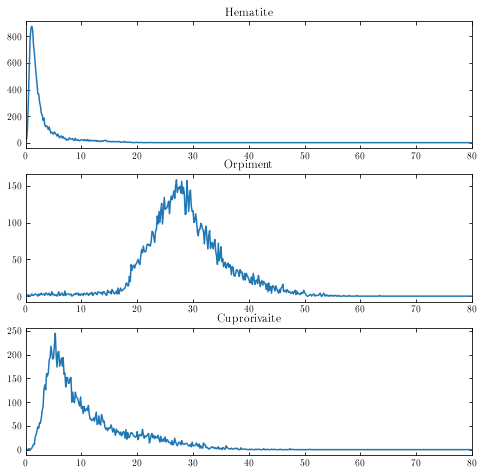

In [25]:
overlap_area = pm.overlap_area()

fig,ax = subplots(len(pm.phases),1,figsize=(8,8))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(overlap_area[:,:,i],bins=512,range=(0,80))
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,80)

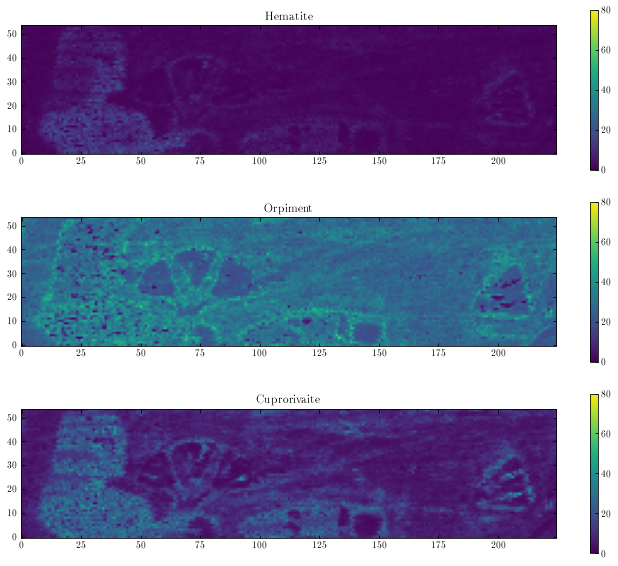

In [26]:
fig,ax = subplots(len(pm.phases),1,figsize=(12,10))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(overlap_area[:,:,i],vmin=0,vmax=80)
    colorbar(p,ax = ax[i])

### Component Ratio

/home/zdenek/.local/lib/python3.9/site-packages/XRDXRFutils/gaussnewton.py:329: RuntimeWarning: invalid value encountered in true_divide
  rescaling = where(z0 > 1e-3, z / z0, 1)
/home/zdenek/.local/lib/python3.9/site-packages/XRDXRFutils/gaussnewton.py:329: RuntimeWarning: divide by zero encountered in true_divide
  rescaling = where(z0 > 1e-3, z / z0, 1)


0.22271635662738057


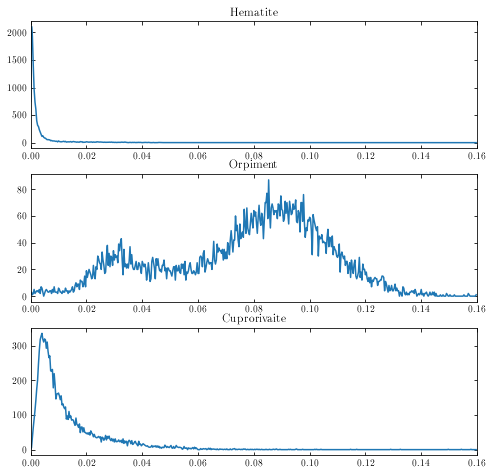

In [27]:
cmp_ratio = pm.component_ratio()

fig,ax = subplots(len(pm.phases),1,figsize=(8,8))
print(cmp_ratio.max())

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(cmp_ratio[:,:,i],bins=512,range=(0,0.16))
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,0.16)

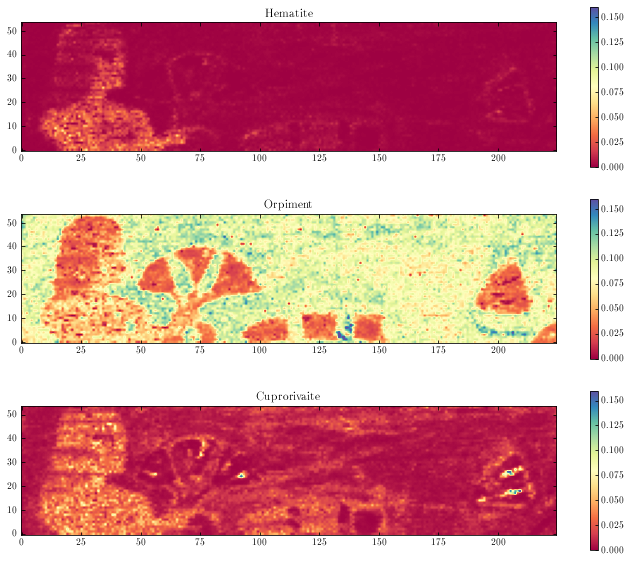

In [29]:
fig,ax= subplots(len(pm.phases),1,figsize=(12,10))
for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow((cmp_ratio[:,:,i]),cmap='Spectral',vmin=0,vmax=0.16)
    colorbar(p,ax = ax[i])

[-1305.68145841  2618.84691862    43.20211896]


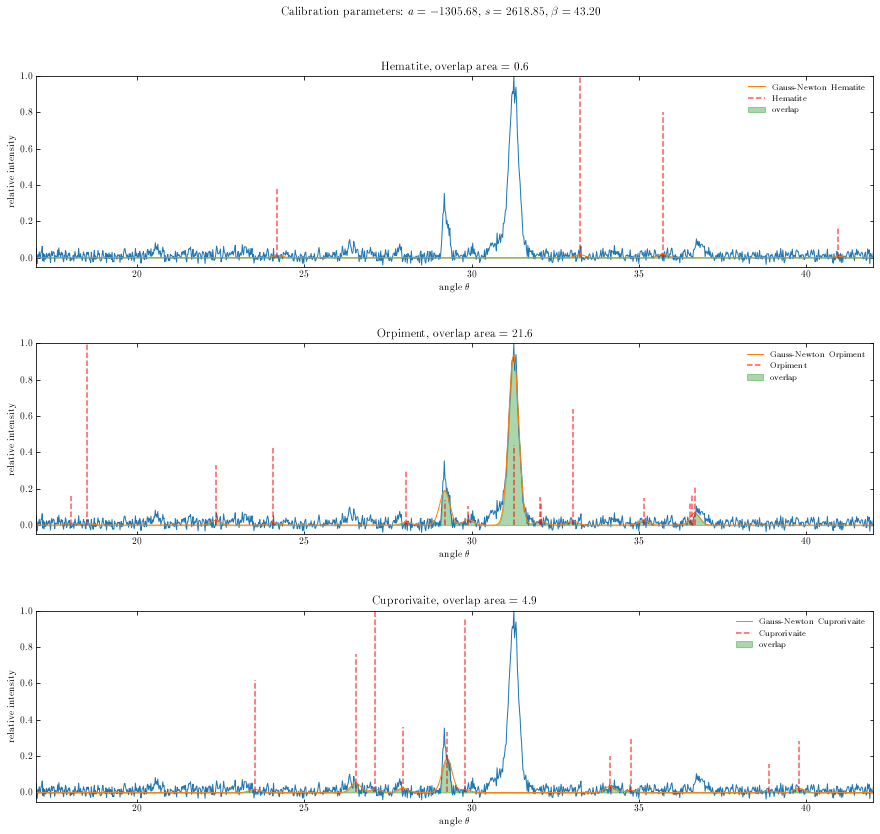

In [42]:
%matplotlib inline
selected = pm.get_pixel(74,35)
#selected = pm.get_pixel(5,5)

fig, axes = subplots(len(selected), 1, figsize = (15, 4 * len(selected)))
fig.subplots_adjust(hspace = 0.4, bottom = 0.06, top = 0.9)
print(selected.opt)

fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(selected.opt[0], selected.opt[1], selected.opt[2]))

for i in range(len(selected)):
    ax = axes[i]
    g = selected[i]
    sca(ax)

    ax.set_title(f'{g.label}, overlap area = {g.overlap_area():.1f}')
    g.plot_spectra(lw = 1)
    g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
    g.phase.plot('r', alpha=0.66)

    fill_between(g.theta.squeeze(), g.overlap(), color = 'g', alpha = 0.33, label='overlap')

    legend(frameon = False)
    ax.set_ylim(-0.05, 1)
    ax.set_xlim(17, 42)
    ax.set_xlabel(r'angle $\theta$')
    ax.set_ylabel(r'relative intensity')

[[0.0225 0.0225 0.0225 0.0225 0.0225 0.0225 0.0225 0.0225 0.0225 0.0225
  0.0225 0.0225 0.0225 0.0225 0.0225]]


Text(0, 0.5, 'relative intensity')

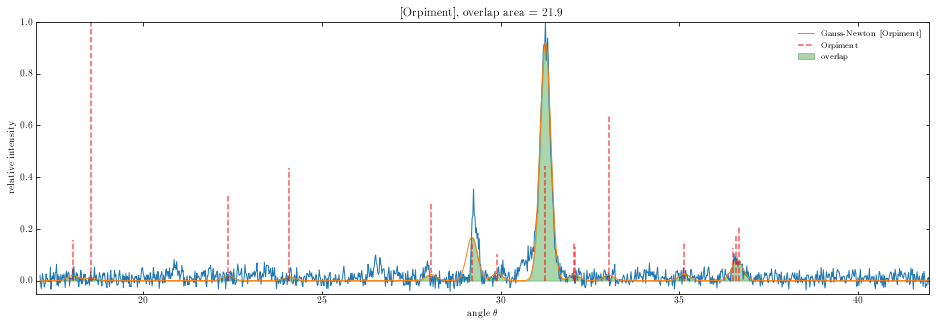

In [41]:
#g = GaussNewton(PhaseList([orpiment,cuprorivaite]),selected.spectrum,sigma_initial=0.15)

g = GaussNewton(PhaseList([orpiment]),selected.spectrum,sigma_initial=0.15)

g.fit_cycle(gamma=True,max_steps = 128)
#g.fit_cycle(a=True,s=True,max_steps = 160,gamma=True,sigma=True)

print(g.sigma2)

figure(figsize=(16,5))

title(f'{g.label}, overlap area = {g.overlap_area():.1f}')

g.plot_spectra(lw = 1)
g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
g.phase.plot(color='r', alpha=0.66)

fill_between(g.theta.squeeze(), g.overlap(), color = 'g', alpha = 0.33, label='overlap')

legend(frameon = False)

ylim(-0.05, 1)
xlim(17, 42)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')